# Swin Transformer

* From the [paper](https://arxiv.org/pdf/2103.14030.pdf)

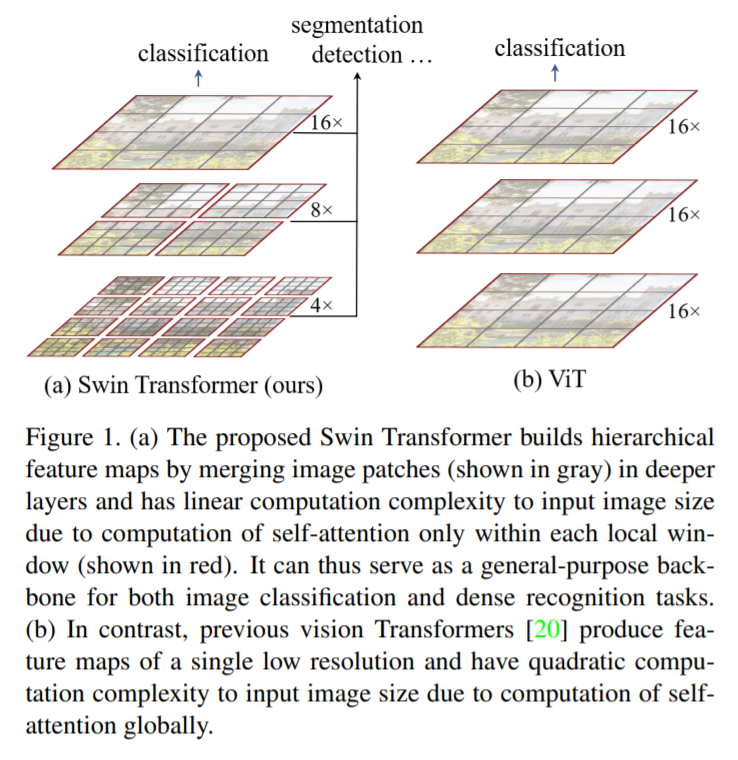

* Challenges in adapting Transformer from language to vision arise from differences between the two domains, such as large variations in the scale of visual entities and the high resolution of pixels in images compared to words in text. To address these differences, we propose a hierarchical Transformer whose representation is computed with Shifted windows. 

* The shifted windowing scheme brings greater efficiency by limiting self-attention computation to non-overlapping local windows while also allowing for cross-window connection. This hierarchical architecture has the flexibility to model at various scales and has linear computational complexity with respect to image size. 

* These qualities of Swin Transformer make it compatible with a broad range of vision tasks


## What this notebook is about

* Thanks for all the [EDA](https://www.kaggle.com/ihelon/g2net-eda-and-modeling). Being new to time series I learned a lot from this.

In [ ]:
!pip install -q nnAudio
!pip install timm

# Load files

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns

from PIL import Image
from matplotlib import pyplot as plt

In [ ]:
train = pd.read_csv('../input/g2net-gravitational-wave-detection/training_labels.csv')
test = pd.read_csv('../input/g2net-gravitational-wave-detection/sample_submission.csv')

def get_file_path(image_id: str, training: bool = True) -> str:
    folder = "train" if training else "test"
    return "../input/g2net-gravitational-wave-detection/{}/{}/{}/{}/{}.npy".format(
        folder, image_id[0], image_id[1], image_id[2], image_id)


train['file_path'] = train['id'].apply(get_file_path)
test['file_path'] = test['id'].apply(lambda x: get_file_path(x, training=False))

display(train.head())
display(test.head())

# Basic EDA

Each .npy file has 3 time series (1 for each detector) and each spans 2 sec and is sampled at 2,048 Hz.

In [ ]:
from typing import Tuple, Callable
import random

def visualize_sample(
    _id: str, 
    target: np.int64, 
    colors: Tuple[str, str, str]=("black", "red", "green"), 
    signal_names: Tuple[str, str, str]=("LIGO Hanford", "LIGO Livingston", "Virgo")
) -> None:
    path = get_file_path(_id)
    x = np.load(path)
    plt.figure(figsize=(16, 7))
    for i in range(3):
        plt.subplot(4, 1, i + 1)
        plt.plot(x[i], color=colors[i])
        plt.legend([signal_names[i]], fontsize=12, loc="lower right")
        
        plt.subplot(4, 1, 4)
        plt.plot(x[i], color=colors[i])
    
    plt.subplot(4, 1, 4)
    plt.legend(signal_names, fontsize=12, loc="lower right")

    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

In [ ]:
for i in random.sample(train.index.tolist(), 3):
    _id = train.iloc[i]["id"]
    target = train.iloc[i]["target"]

    visualize_sample(_id, target)

## Sepectogram with librosa

In [ ]:
import librosa
import librosa.display

def visualize_sample_spectogram(
    _id: str, 
    target: np.int64,
    signal_names: Tuple[str, str, str]=("LIGO Hanford", "LIGO Livingston", "Virgo")
) -> None:
    x = np.load(get_file_path(_id))
    plt.figure(figsize=(16, 5))
    for i in range(3):
        X = librosa.stft(x[i] / x[i].max())
        Xdb = librosa.amplitude_to_db(abs(X))
        plt.subplot(1, 3, i + 1)
        librosa.display.specshow(Xdb, sr=2048, x_axis="time", y_axis="hz", vmin=-30, vmax=50) 
        plt.colorbar()
        plt.title(signal_names[i], fontsize=14)

    plt.suptitle(f"id: {_id} target: {target}", fontsize=16)
    plt.show()

In [ ]:
for i in random.sample(train.index.tolist(), 3):
    _id = train.iloc[i]["id"]
    target = train.iloc[i]["target"]

    visualize_sample_spectogram(_id, target)

## QTransform

In [ ]:
import torch
from nnAudio.Spectrogram import CQT1992v2

def apply_qtransform(
        waves: np.ndarray, transform=CQT1992v2(sr=2048, fmin=20, fmax=1024, hop_length=64)
) -> torch.Tensor:
    waves = np.hstack(waves)
    waves = waves / np.max(waves)
    waves = torch.from_numpy(waves).float()
    image = transform(waves)
    return image

In [ ]:
for i in range(3):
    waves = np.load(train.loc[i, 'file_path'])
    image = apply_qtransform(waves)
    target = train.loc[i, 'target']
    plt.figure(figsize=(10, 8))
    plt.imshow(image[0])
    plt.title(f"target: {target}")
    plt.show()

One good thing about simulated that, it is balanced

In [ ]:
train['target'].hist()

# Args

In [ ]:
class Args:
    debug=False
    apex=False
    print_freq=500
    num_workers=4
#     model_name='swin_base_patch4_window12_384'
    model_name='swin_large_patch4_window12_384'
    scheduler='CosineAnnealingWarmRestarts' 
    epochs=3
    T_0=3 # CosineAnnealingWarmRestarts
    lr=1e-4
    n_fold=5
    min_lr=1e-6
    batch_size=32
    weight_decay=1e-6
    gradient_accumulation_steps=1
    max_grad_norm=1000
    qtransform_params={"sr": 2048, "fmin": 20, "fmax": 1024, "hop_length": 32, "bins_per_octave": 8}
    seed=42
    target_size=1
    target_col='target'
    trn_fold=[0] #[# cross validation]
    train=True

if Args.debug:
    Args.epochs = 1
    train = train.sample(n=10000, random_state=Args.seed).reset_index(drop=True)

In [ ]:
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)


def get_score(y_true, y_pred):
    score = roc_auc_score(y_true, y_pred)
    return score


def init_logger(log_file=OUTPUT_DIR+'train.log'):
    from logging import getLogger, INFO, FileHandler,  Formatter,  StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(seed=Args.seed)

# Torch Custom Dataset

In [ ]:
import os
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter

import scipy as sp
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models
from torch.optim import Adam, SGD
from torch.nn.parameter import Parameter
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau

import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

import timm

from torch.cuda.amp import autocast, GradScaler

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def seed_everything(seed: int) -> None:
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
class G2NetDataset(torch.utils.data.Dataset):
    def __init__(self, df, dir_, augmentations=None, ext=".npy"):
        self.df = df
#         self.file_names = df['file_path'].values
        self.dir_ = dir_
        self.file_ids = df['id'].values
        self.targets = df[Args.target_col].values
#         self.wave_transform = CQT1992v2(**Args.qtransform_params)
        self.augmentations = augmentations
        self.ext = ext
        self.pad = nn.ReplicationPad2d((0, 0, 2, 3))
    
    def __len__(self) -> int:
        return len(self.df)
    
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        file_id = self.file_ids[idx]
        target = self.targets[idx]
        signals = list()
        path = os.path.join(self.dir_, file_id + self.ext)
        signal = np.load(path).astype('float32')
#         signals.append(path)
        signal = torch.from_numpy(signal).float().unsqueeze(0).unsqueeze(0)
        
        signal = self.pad(signal).squeeze(0)
        signal = signal.repeat((3, 1, 1))
        return signal, torch.tensor(target).float()
    
#     def apply_qtransform(self, waves: np.ndarray, transform: Callable) -> torch.Tensor:
#         waves = np.hstack(waves)
#         waves /= np.max(waves)
#         waves = torch.from_numpy(waves).float()
#         image = transform(waves)
#         return image

In [ ]:
def get_augmentations(*, data):
    
    if data == 'train':
        return A.Compose([
            ToTensorV2(),
        ])

    elif data == 'valid':
        return A.Compose([
            ToTensorV2(),
        ])

In [ ]:
train_dataset = G2NetDataset(
    train,
    "../input/g2net-n-mels-128-train-images",
    get_augmentations(data='train'),
)

for i in range(5):
    plt.figure(figsize=(16,12))
    image, target = train_dataset[i]
    print(image.shape)
#     plt.imshow(image[0])
#     plt.title(f'label: {label}')
#     plt.show()

# Modelling

In [ ]:
class G2NetCustomModel(nn.Module):
    def __init__(self, cfg, pretrained=False):
        super().__init__()
        self.cfg = cfg
        self.model = timm.create_model(self.cfg.model_name, img_size=(32, 128), pretrained=pretrained, in_chans=3)
        self.n_features = self.model.head.in_features
        self.model.head = nn.Linear(self.n_features, self.cfg.target_size)

    def forward(self, x):
        output = self.model(x)
        return output

m = G2NetCustomModel(Args)
x = torch.ones((1, 3, 32, 128))
print(m(x))

# Utils

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count
        
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    if Args.apex:
        scaler = GradScaler()
        
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, labels) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        
        if Args.apex:
            with autocast():
                y_preds = model(images)
                loss = criterion(y_preds.view(-1), labels)
        else:
            y_preds = model(images)
            loss = criterion(y_preds.view(-1), labels)
        
        # backprop
        losses.update(loss.item(), batch_size)
        if Args.gradient_accumulation_steps > 1:
            loss = loss / Args.gradient_accumulation_steps
        if Args.apex:
            scaler.scale(loss).backward()
        else:
            loss.backward()
            
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), Args.max_grad_norm)
        if (step + 1) % Args.gradient_accumulation_steps == 0:
            if Args.apex:
                scaler.step(optimizer)
                scaler.update()
            else:
                optimizer.step()
            optimizer.zero_grad()
            global_step += 1
        batch_time.update(time.time() - end)
        end = time.time()
        if step % Args.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.6f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
    return losses.avg

In [ ]:
def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    
    for step, (images, labels) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds.view(-1), labels)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.sigmoid().to('cpu').numpy())
        if Args.gradient_accumulation_steps > 1:
            loss = loss / Args.gradient_accumulation_steps
        batch_time.update(time.time() - end)
        end = time.time()
        if step % Args.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    return losses.avg, predictions

In [ ]:
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    trn_idx = folds[folds['fold'] != fold].index
    val_idx = folds[folds['fold'] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)
    valid_labels = valid_folds[Args.target_col].values

    train_dataset = G2NetDataset(train_folds, "../input/g2net-n-mels-128-train-images", augmentations=get_augmentations(data='train'))
    valid_dataset = G2NetDataset(valid_folds, "../input/g2net-n-mels-128-train-images", augmentations=get_augmentations(data='train'))

    train_loader = torch.utils.data.DataLoader(train_dataset,
                              batch_size=Args.batch_size, 
                              shuffle=True, 
                              num_workers=Args.num_workers, pin_memory=False, drop_last=True)
    valid_loader = torch.utils.data.DataLoader(valid_dataset, 
                              batch_size=Args.batch_size * 2, 
                              shuffle=False, 
                              num_workers=Args.num_workers, pin_memory=False, drop_last=False)
    # ====================================================
    # scheduler 
    # ====================================================
    def get_scheduler(optimizer):
        if Args.scheduler=='ReduceLROnPlateau':
            scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=Args.factor, patience=Args.patience, verbose=True, eps=Args.eps)
        elif Args.scheduler=='CosineAnnealingLR':
            scheduler = CosineAnnealingLR(optimizer, T_max=Args.T_max, eta_min=Args.min_lr, last_epoch=-1)
        elif Args.scheduler=='CosineAnnealingWarmRestarts':
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=Args.T_0, T_mult=1, eta_min=Args.min_lr, last_epoch=-1)
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = G2NetCustomModel(Args, pretrained=False)
    model.to(device)

    optimizer = Adam(model.parameters(), lr=Args.lr, weight_decay=Args.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # loop
    # ====================================================
    criterion = nn.BCEWithLogitsLoss()

    best_score = 0.
    best_loss = np.inf
    
    for epoch in range(Args.epochs):
        
        start_time = time.time()
        
        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        
        if isinstance(scheduler, ReduceLROnPlateau):
            scheduler.step(avg_val_loss)
        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()
        elif isinstance(scheduler, CosineAnnealingWarmRestarts):
            scheduler.step()

        # scoring
        score = get_score(valid_labels, preds)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        
        if score > best_score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{Args.model_name}_fold{fold}_best_score.pth')
        
        if avg_val_loss < best_loss:
            best_loss = avg_val_loss
            LOGGER.info(f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
            torch.save({'model': model.state_dict(), 
                        'preds': preds},
                        OUTPUT_DIR+f'{Args.model_name}_fold{fold}_best_loss.pth')
    
    valid_folds['preds'] = torch.load(OUTPUT_DIR+f'{Args.model_name}_fold{fold}_best_score.pth', 
                                      map_location=torch.device('cpu'))['preds']

    return valid_folds
    

# Train

In [ ]:
def main():

    def get_result(result_df):
        preds = result_df['preds'].values
        labels = result_df[Args.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if Args.train:
        # train 
        oof_df = pd.DataFrame()
        for fold in range(Args.n_fold):
            if fold in Args.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR+'df_of.csv', index=False)

# CV Folds Split

In [ ]:
Fold = StratifiedKFold(n_splits=Args.n_fold, shuffle=True, random_state=Args.seed)
for n, (train_index, val_index) in enumerate(Fold.split(train, train[Args.target_col])):
    train.loc[val_index, 'fold'] = int(n)
train['fold'] = train['fold'].astype(int)
display(train.groupby(['fold', 'target']).size())

In [ ]:
main()